In [43]:
import pandas as pd 
import plotly.express as px
import seaborn as sns
import plotly.subplots as sp
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv('HR_comma_sep.csv')

In [3]:
df.shape

(14999, 10)

In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [6]:
#chaging this for now for EDA
df['left'] = df['left'].astype('object')

In [7]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [8]:
print('Number of duplicate rows:', df.duplicated().sum())

#There seems to be a large nuber of duplicate rows. I woulld assume that maybe some duplatices are correcct employees
#however it will be hard to belive that two employees have the exact same response 

Number of duplicate rows: 3008


In [9]:
df = df.drop_duplicates(keep='first')

In [10]:
df.shape

(11991, 10)

In [11]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


# Running EDA

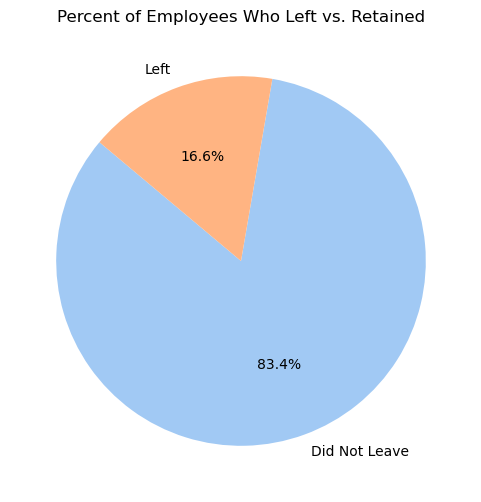

In [96]:
left_count = df['left'].value_counts()


labels = ['Did Not Leave', 'Left']
sizes = left_count.values
colors = sns.color_palette('pastel')[0:2]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percent of Employees Who Left vs. Retained')


plt.show()

In [102]:
df_corr = df

df_corr['left'] = df_corr['left'].astype('int64')
correlation_matrix = df_corr.corr()
correlation_heatmap = px.imshow(correlation_matrix)
correlation_heatmap.update_layout(title='Correlation Heatmap')
correlation_heatmap.show()

/var/folders/g9/n9dpfw1d3pjf7dqwrht5y8h40000gn/T/ipykernel_80830/1749970249.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



In [14]:
salary_distribution = px.bar(df['salary'].value_counts().reset_index(), x='index', y='salary',
                             labels={'index': 'Salary', 'salary': 'Count'},
                             title='Salary Distribution')
salary_distribution.show()

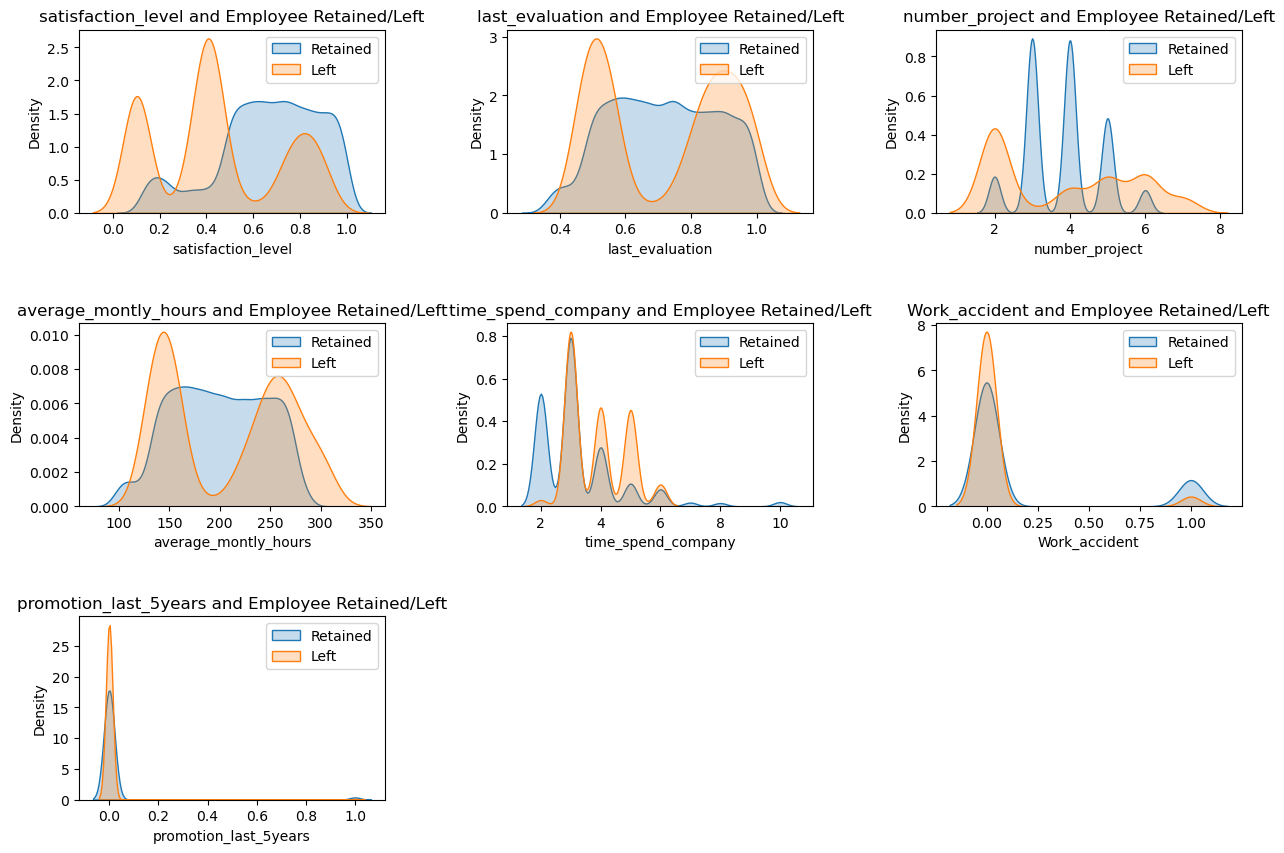

In [97]:
numerical_columns = ['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years']

# Define the number of rows and columns for the grid
n_rows = 3
n_cols = 3

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
fig.subplots_adjust(wspace=0.4, hspace=0.6)  # Adjust the spacing between subplots

# Iterate through numerical columns and create KDE plots in subplots
for i, column in enumerate(numerical_columns):
    row = i // n_cols  # Calculate the row index
    col = i % n_cols   # Calculate the column index

    sns.kdeplot(data=df[df['left'] == 0][column], label='Retained', fill=True, ax=axes[row, col])
    sns.kdeplot(data=df[df['left'] == 1][column], label='Left', fill=True, ax=axes[row, col])
    axes[row, col].set_title(f'{column} and Employee Retained/Left')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Density')
    axes[row, col].legend()

# Hide any empty subplots (if the number of columns is less than n_cols)
for i in range(len(numerical_columns), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row, col])

plt.show()

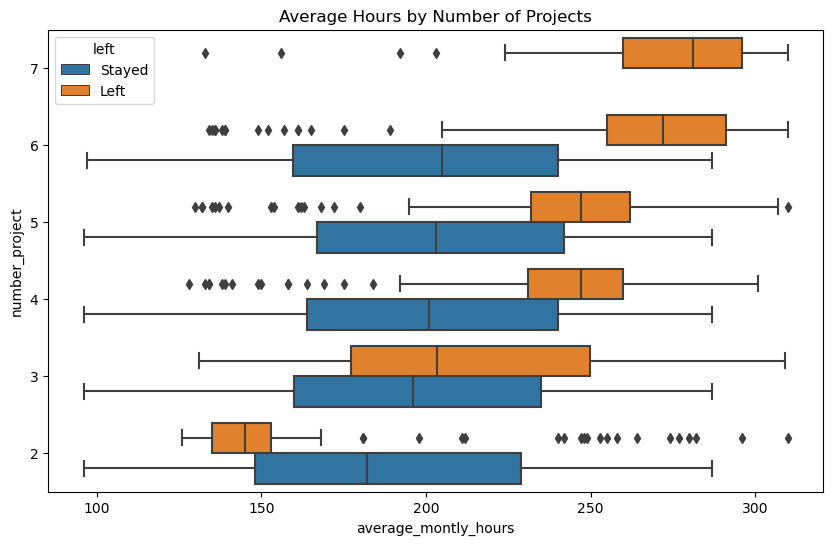

In [99]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(data=df, x='average_montly_hours', y='number_project', hue='left', orient='h')

# Set custom legend labels
legend_labels = {0: 'Stayed', 1: 'Left'}
legend = box_plot.get_legend()
for text, label in zip(legend.texts, legend_labels.values()):
    text.set_text(label)

plt.gca().invert_yaxis()
plt.title('Average Hours by Number of Projects')
plt.show()

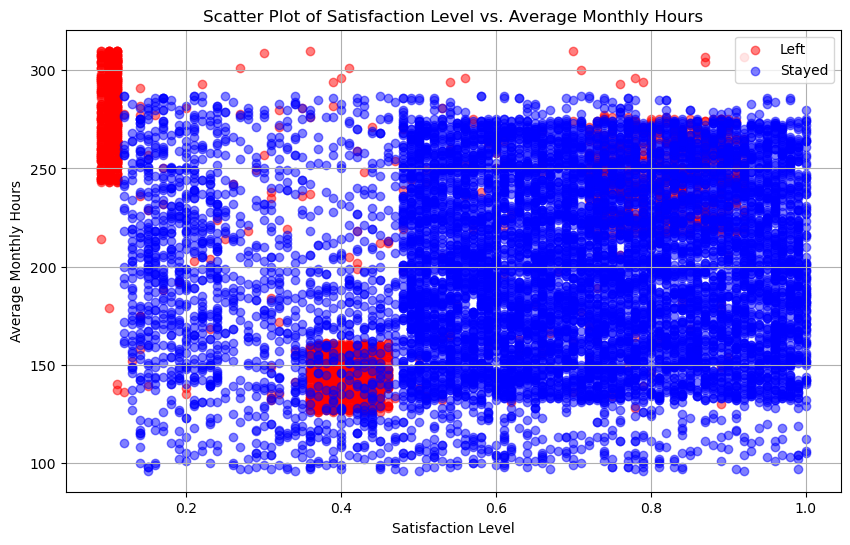

In [21]:
left_employees = df[df['left'] == 1]
stayed_employees = df[df['left'] == 0]

plt.figure(figsize=(10, 6))

plt.scatter(left_employees['satisfaction_level'], left_employees['average_montly_hours'], c='red', label='Left', alpha=0.5)

plt.scatter(stayed_employees['satisfaction_level'], stayed_employees['average_montly_hours'], c='blue', label='Stayed', alpha=0.5)

plt.title('Scatter Plot of Satisfaction Level vs. Average Monthly Hours')
plt.xlabel('Satisfaction Level')
plt.ylabel('Average Monthly Hours')
plt.legend()
plt.grid(True)
plt.show()





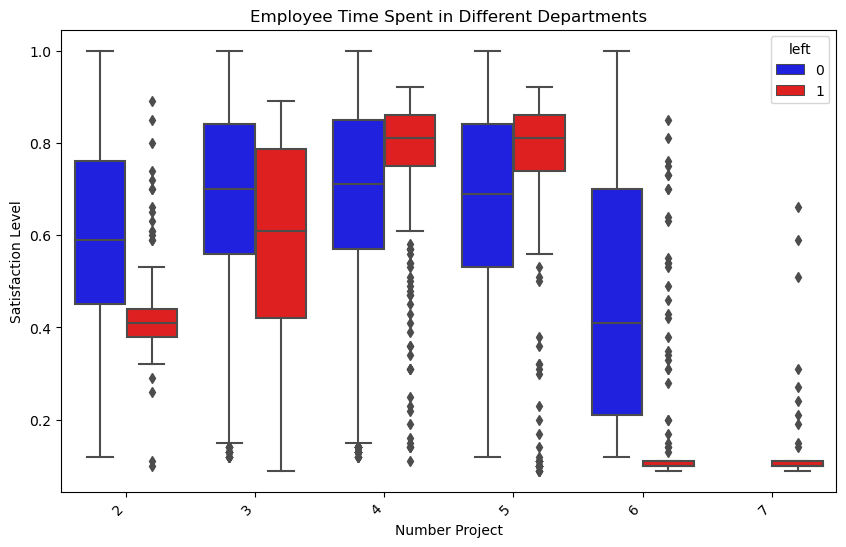

In [90]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(data=df, x='number_project', y='satisfaction_level', hue='left', palette={0: 'blue', 1: 'red'}, orient='v')
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set the labels and title
plt.xlabel('Number Project')
plt.ylabel('Satisfaction Level')
plt.title('Employee Time Spent in Different Departments')

# Show the plot
plt.show()

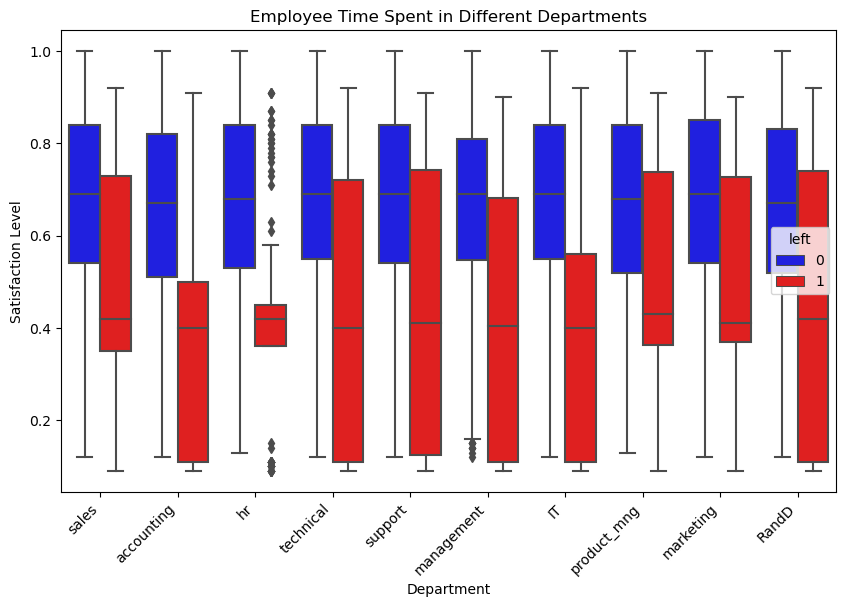

In [89]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(data=df, x='Department', y='satisfaction_level', hue='left', palette={0: 'blue', 1: 'red'}, orient='v')
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45, horizontalalignment='right')

# Set the labels and title
plt.xlabel('Department')
plt.ylabel('Satisfaction Level')
plt.title('Employee Time Spent in Different Departments')

# Show the plot
plt.show()

In [24]:
avg_time_left = df[df['left'] == 1]['time_spend_company'].mean()
print(avg_time_left)

3.8814665996986437


# Modeling

In [27]:
df_model = df.copy()
df_model.head()

df_model['left'] = df_model['left'].astype('int64')

In [28]:
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,satisfaction_category
0,0.38,0.53,2,157,3,0,1,0,sales,low,medium
1,0.80,0.86,5,262,6,0,1,0,sales,medium,high
2,0.11,0.88,7,272,4,0,1,0,sales,medium,low
3,0.72,0.87,5,223,5,0,1,0,sales,low,high
4,0.37,0.52,2,159,3,0,1,0,sales,low,medium


In [29]:
salary_mapping = {"low": 0, "medium": 1, "high": 2}

# Apply the mapping to the 'salary' column
df_model['salary'] = df_model['salary'].map(salary_mapping)

In [30]:
df_model = pd.get_dummies(df_model, columns=['Department'], prefix='Dept')

In [31]:
df_model = df_model.drop('satisfaction_category',axis=1)

In [32]:

df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Dept_IT,Dept_RandD,Dept_accounting,Dept_hr,Dept_management,Dept_marketing,Dept_product_mng,Dept_sales,Dept_support,Dept_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [33]:
X = df_model.drop('left', axis=1)
y = df_model['left']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [34]:
rf_classifier = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [35]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, scoring='recall')

grid_search.fit(X_train, y_train)

/Users/helen/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/helen/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/helen/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='recall')

In [36]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Estimator:", best_estimator)

Best Parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(max_depth=20, max_features='auto', random_state=42)


In [37]:
y_pred = best_estimator.predict(X_test)

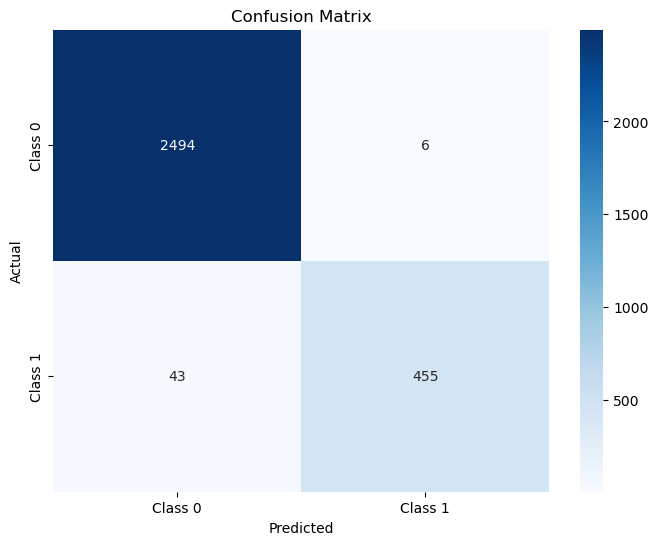

In [48]:
class_labels = ['Class 0', 'Class 1']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [39]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.99
Recall: 0.91
F1-Score: 0.95
Accuracy: 0.98


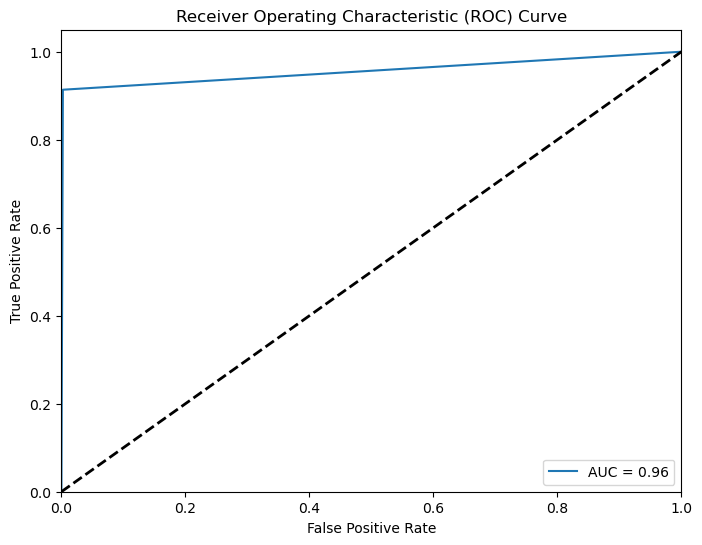

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

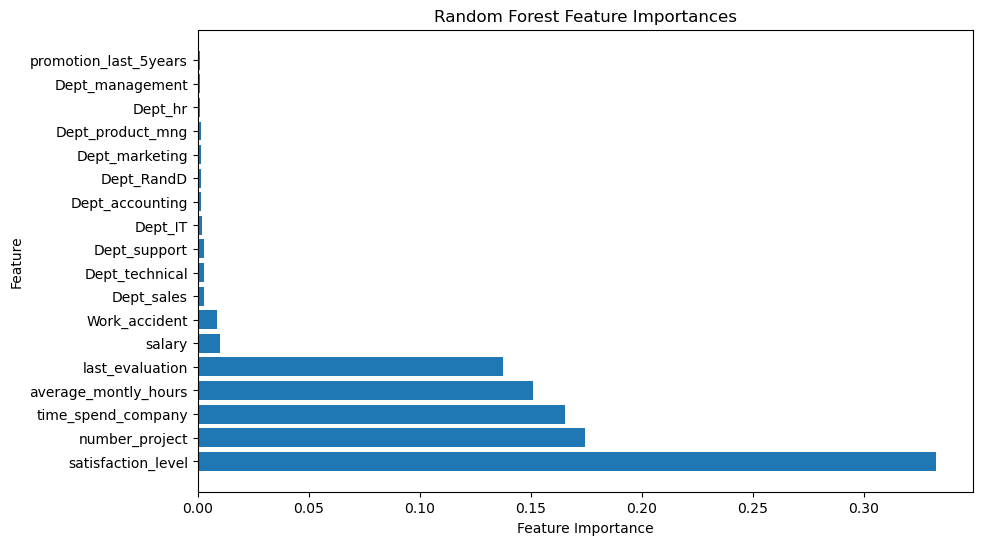

In [41]:
feature_importances = best_estimator.feature_importances_

feature_names = X_train.columns  # Replace with the actual feature names

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Create a horizontal bar chart to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx])
plt.yticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()





# Modeling With Sampling

In [44]:
#testing how model does with sampling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oversampler = RandomOverSampler(sampling_strategy='auto')  
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_resampled, y_resampled)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Accuracy: 0.98
Precision: 0.98
Recall: 0.90
F1 Score: 0.94
ROC AUC Score: 0.95


In [45]:
X_resampled.shape

(14010, 18)

In [46]:
y_resampled.value_counts()

0    7005
1    7005
Name: left, dtype: int64